# doc2vec 추천

# ---------------------------------------------

## 라이브러리 호출

In [1]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import nltk

from PIL import Image
from io import BytesIO

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from gensim.models import Word2Vec # word2vec의 알고리즘 호출
from gensim.models import KeyedVectors
from gensim.models.word2vec import Word2Vec

from sklearn.metrics.pairwise import cosine_similarity

# Download stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\multicampus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 전체 데이터 개수

In [2]:
df = pd.read_excel("gamedata_eng.xlsx")
print('Total number of documents:', len(df))

Total number of documents: 57068


In [3]:
# Preview the first 5 rows
df.head(10)

,appid,name,short_description,price,categories,genres,recommendations,release_date,developers,metacritic,image,about_the_game,screenshots,type
0,1610530,The Annoying Game,"Run, jump, die, repeat. Help Teddy on his jour...",440000.0,['Single-player'],"['Casual', 'Indie']",NaN,"14 Jul, 2021","['Michal Ambrozej', 'The Piano Chap']",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,'The Annoying Game' is a retro style platforme...,['https://cdn.akamai.steamstatic.com/steam/app...,game
1,1610610,CallMeProducer101,"作为曾经的电视台天才制作人,你要担负起经营一个全新视频网站的责任 节目制作，节目安排，营销规...",220000.0,"['Single-player', 'Steam Cloud']","['Simulation', 'Strategy']",NaN,"18 May, 2021",['随便做做游戏组'],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,"中国内地娱乐视频网站模拟器<br />_x000D_\n作为一个曾经的电视台天才制作人,因为...",['https://cdn.akamai.steamstatic.com/steam/app...,game
2,1610630,BURGER MAN,&quot;BURGER MAN&quot; is a hardcore 2D platfo...,32000.0,"['Single-player', 'Steam Achievements']","['Casual', 'Indie']",NaN,"6 May, 2021",['Rex Junior'],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,&quot;BURGER MAN&quot; is a hardcore side-scro...,['https://cdn.akamai.steamstatic.com/steam/app...,game
3,1610650,●LIVE IN DUNGEON,●LIVE IN DUNGEON is an RPG where you play as a...,682000.0,['Single-player'],"['Indie', 'RPG']",NaN,"4 Jun, 2021",['Heaviside Creations'],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,"Wonderlucia, an alternate world where streamin...",['https://cdn.akamai.steamstatic.com/steam/app...,game
4,1610660,Throw Knives,Throw Knives is a new casual and addictive ret...,105000.0,['Single-player'],"['Casual', 'Indie', 'Simulation', 'Strategy']",NaN,"6 May, 2021",['Stas Paty9mkin'],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,<i> <strong> Throw Knives </strong> </i> is a ...,['https://cdn.akamai.steamstatic.com/steam/app...,game
5,1610670,Detective VR,The mysterious missing of a collector challeng...,2050000.0,"['Single-player', 'Tracked Controller Support'...",['Adventure'],NaN,"19 Aug, 2021",['MightyPlus'],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,"<img src=""https://cdn.akamai.steamstatic.com/s...",['https://cdn.akamai.steamstatic.com/steam/app...,game
6,1610700,Clutter 1000,The greatest Clutter yet! Clutter 1000 is the ...,315000.0,['Single-player'],"['Casual', 'Indie']",NaN,"1 Jun, 2021",['Puzzles by Joe'],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,The greatest Clutter yet! Clutter 1000 is the ...,['https://cdn.akamai.steamstatic.com/steam/app...,game
7,1610730,Fallen from the sky,Fallen from the sky - a casual game with adven...,105000.0,['Single-player'],"['Adventure', 'Casual', 'Indie']",NaN,"6 May, 2021",['PancakeGames'],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,<strong> <i> Fallen from the sky </i> </strong...,['https://cdn.akamai.steamstatic.com/steam/app...,game
8,1609800,Akinofa,Akinofa is an arcade shoot 'em up with Rogueli...,550000.0,"['Single-player', 'Steam Achievements', 'Full ...","['Action', 'Indie']",NaN,"15 Jul, 2021",['Pixel Lantern'],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,"<img src=""https://cdn.akamai.steamstatic.com/s...",['https://cdn.akamai.steamstatic.com/steam/app...,game
9,1609860,Dungeonite,Choose a character and obliterate your friends...,703000.0,"['Multi-player', 'PvP', 'Online PvP']","['Action', 'Casual']",NaN,"18 Jun, 2021",['Pants Robot LLC'],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,Choose a Character and obliterate your friends...,['https://cdn.akamai.steamstatic.com/steam/app...,game


# 날짜순 정렬은 힘들다. => 최신 버전은 skip
- df['release_date'] = pd.to_datetime(df['release_date'])
- Unknown string format: 1/ago./2019
- time data 'Feb 2021' does not match format '%d %b, %Y' (match) 
- 날짜가 이상하게 나옴


# 데이터 살펴보기

In [4]:
print('데이터의 총 개수: ', len(df))
print('metacritic이 없는 데이터의 개수 : ', df['metacritic'].isnull().sum())
print('추천이 없는 데이터의 개수 : ',df['recommendations'].isnull().sum())

데이터의 총 개수:  57068
metacritic이 없는 데이터의 개수 :  53528
추천이 없는 데이터의 개수 :  44247


# metacritic 없는 데이터를 제거한 dataset 생성

In [5]:
# metacritc 없는 데이터를 제거한 dataset 생성
df_metacritic=df.dropna(subset=['metacritic'],how='any',axis=0) 
print('meta 개수 : ',len(df_metacritic))

meta 개수 :  3540


In [6]:
df_metacritic.columns

Index(['appid', 'name', 'short_description', 'price', 'categories', 'genres',
       'recommendations', 'release_date', 'developers', 'metacritic', 'image',
       'about_the_game', 'screenshots', 'type'],
      dtype='object')

# metacritic이 있는 데이터에서 상위 200개를 추출 (recommendation 고려)

In [7]:
# 정렬을 하기위해, 숫자형으로 변환하고 정렬
df_metacritic['metacritic'] = pd.to_numeric(df_metacritic['metacritic'])
df_metacritic['recommendations'] = pd.to_numeric(df_metacritic['recommendations'])

df_metacritic = df_metacritic.sort_values(by=['metacritic','recommendations'], ascending=False)

C:\Users\multicampus\AppData\Local\Temp\ipykernel_13708\2900518277.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metacritic['metacritic'] = pd.to_numeric(df_metacritic['metacritic'])
C:\Users\multicampus\AppData\Local\Temp\ipykernel_13708\2900518277.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metacritic['recommendations'] = pd.to_numeric(df_metacritic['recommendations'])


In [8]:
df_metacritic.head(10)

,appid,name,short_description,price,categories,genres,recommendations,release_date,developers,metacritic,image,about_the_game,screenshots,type
54506,632470,Disco Elysium,Disco Elysium - The Final Cut is a groundbreak...,1025000.0,"['Single-player', 'Steam Achievements', 'Full ...",['RPG'],68591.0,"15 Oct, 2019",['ZA/UM'],97.0,https://cdn.akamai.steamstatic.com/steam/apps/...,"<img src=""https://cdn.akamai.steamstatic.com/s...",['https://cdn.akamai.steamstatic.com/steam/app...,game
50102,220,Half-Life 2,1998. HALF-LIFE sends a shock through the game...,110000.0,"['Single-player', 'Steam Achievements', 'Steam...",['Action'],123801.0,"16 Nov, 2004",['Valve'],96.0,https://cdn.akamai.steamstatic.com/steam/apps/...,1998. HALF-LIFE sends a shock through the game...,['https://cdn.akamai.steamstatic.com/steam/app...,game
50116,70,Half-Life,Named Game of the Year by over 50 publications...,105000.0,"['Single-player', 'Multi-player', 'PvP', 'Onli...",['Action'],69499.0,"8 Nov, 1998",['Valve'],96.0,https://cdn.akamai.steamstatic.com/steam/apps/...,Named Game of the Year by over 50 publications...,['https://cdn.akamai.steamstatic.com/steam/app...,game
50096,620,Portal 2,The &quot;Perpetual Testing Initiative&quot; h...,110000.0,"['Single-player', 'Multi-player', 'Co-op', 'On...","['Action', 'Adventure']",272979.0,"18 Apr, 2011",['Valve'],95.0,https://cdn.akamai.steamstatic.com/steam/apps/...,Portal 2 draws from the award-winning formula ...,['https://cdn.akamai.steamstatic.com/steam/app...,game
50097,659,Portal 2 - Pre-order,The &quot;Perpetual Testing Initiative&quot; h...,110000.0,"['Single-player', 'Multi-player', 'Co-op', 'On...","['Action', 'Adventure']",272979.0,"18 Apr, 2011",['Valve'],95.0,https://cdn.akamai.steamstatic.com/steam/apps/...,Portal 2 draws from the award-winning formula ...,['https://cdn.akamai.steamstatic.com/steam/app...,game
10676,1687950,Persona 5 Royal,Don the mask and join the Phantom Thieves of H...,5199.0,"['Single-player', 'Steam Achievements', 'Full ...",['RPG'],24707.0,"20 Oct, 2022",['ATLUS'],95.0,https://cdn.akamai.steamstatic.com/steam/apps/...,"<img src=""https://cdn.akamai.steamstatic.com/s...",['https://cdn.akamai.steamstatic.com/steam/app...,game
54999,1245620,ELDEN RING,"THE NEW FANTASY ACTION RPG. Rise, Tarnished, a...",6480000.0,"['Single-player', 'Multi-player', 'PvP', 'Onli...","['Action', 'RPG']",492461.0,"24 Feb, 2022",['FromSoftware Inc.'],94.0,https://cdn.akamai.steamstatic.com/steam/apps/...,"<img src=""https://cdn.akamai.steamstatic.com/s...",['https://cdn.akamai.steamstatic.com/steam/app...,game
47313,72850,The Elder Scrolls V: Skyrim,EPIC FANTASY REBORN The next chapter in the hi...,2100000.0,"['Single-player', 'Steam Achievements', 'Steam...",['RPG'],180301.0,"10 Nov, 2011",['Bethesda Game Studios'],94.0,https://cdn.akamai.steamstatic.com/steam/apps/...,<strong>EPIC FANTASY REBORN</strong><br>\t\t\t...,['https://cdn.akamai.steamstatic.com/steam/app...,game
49905,8870,BioShock Infinite,"Indebted to the wrong people, with his life on...",562.0,"['Single-player', 'Steam Achievements', 'Full ...",['Action'],97350.0,"25 Mar, 2013","['Irrational Games', 'Virtual Programming (Lin...",94.0,https://cdn.akamai.steamstatic.com/steam/apps/...,"Indebted to the wrong people, with his life on...",['https://cdn.akamai.steamstatic.com/steam/app...,game
49697,22330,The Elder Scrolls IV: Oblivion,The Elder Scrolls IV: Oblivion® Game of the Ye...,519000.0,"['Single-player', 'Steam Cloud']",['RPG'],32165.0,"16 Jun, 2009",['Bethesda Game Studios'],94.0,https://cdn.akamai.steamstatic.com/steam/apps/...,The Elder Scrolls IV: Oblivion® Game of the Ye...,['https://cdn.akamai.steamstatic.com/steam/app...,game


In [9]:
# metacritic 있는 데이터에서 200개를 game_list에 담아준다.
game_list = pd.DataFrame()
game_list = pd.concat((game_list,df_metacritic[:201]))
game_list


,appid,name,short_description,price,categories,genres,recommendations,release_date,developers,metacritic,image,about_the_game,screenshots,type
54506,632470,Disco Elysium,Disco Elysium - The Final Cut is a groundbreak...,1025000.0,"['Single-player', 'Steam Achievements', 'Full ...",['RPG'],68591.0,"15 Oct, 2019",['ZA/UM'],97.0,https://cdn.akamai.steamstatic.com/steam/apps/...,"<img src=""https://cdn.akamai.steamstatic.com/s...",['https://cdn.akamai.steamstatic.com/steam/app...,game
50102,220,Half-Life 2,1998. HALF-LIFE sends a shock through the game...,110000.0,"['Single-player', 'Steam Achievements', 'Steam...",['Action'],123801.0,"16 Nov, 2004",['Valve'],96.0,https://cdn.akamai.steamstatic.com/steam/apps/...,1998. HALF-LIFE sends a shock through the game...,['https://cdn.akamai.steamstatic.com/steam/app...,game
50116,70,Half-Life,Named Game of the Year by over 50 publications...,105000.0,"['Single-player', 'Multi-player', 'PvP', 'Onli...",['Action'],69499.0,"8 Nov, 1998",['Valve'],96.0,https://cdn.akamai.steamstatic.com/steam/apps/...,Named Game of the Year by over 50 publications...,['https://cdn.akamai.steamstatic.com/steam/app...,game
50096,620,Portal 2,The &quot;Perpetual Testing Initiative&quot; h...,110000.0,"['Single-player', 'Multi-player', 'Co-op', 'On...","['Action', 'Adventure']",272979.0,"18 Apr, 2011",['Valve'],95.0,https://cdn.akamai.steamstatic.com/steam/apps/...,Portal 2 draws from the award-winning formula ...,['https://cdn.akamai.steamstatic.com/steam/app...,game
50097,659,Portal 2 - Pre-order,The &quot;Perpetual Testing Initiative&quot; h...,110000.0,"['Single-player', 'Multi-player', 'Co-op', 'On...","['Action', 'Adventure']",272979.0,"18 Apr, 2011",['Valve'],95.0,https://cdn.akamai.steamstatic.com/steam/apps/...,Portal 2 draws from the award-winning formula ...,['https://cdn.akamai.steamstatic.com/steam/app...,game
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49819,15190,Brothers in Arms: Road to Hill 30,Based on a true story. Set during the famous a...,220000.0,['Single-player'],['Action'],1348.0,"13 May, 2008",['Gearbox Software'],87.0,https://cdn.akamai.steamstatic.com/steam/apps/...,Based on a true story. Set during the famous a...,['https://cdn.akamai.steamstatic.com/steam/app...,game
53615,269050,Year Walk,In the old days man tried to catch a glimpse o...,650000.0,"['Single-player', 'Steam Achievements']","['Adventure', 'Indie']",1176.0,"6 Mar, 2014",['Simogo'],87.0,https://cdn.akamai.steamstatic.com/steam/apps/...,<i><strong>In the old days man tried to catch ...,['https://cdn.akamai.steamstatic.com/steam/app...,game
55969,1350200,IMMORTALITY,Marissa Marcel was a film star. She made three...,1537000.0,"['Single-player', 'Steam Achievements', 'Full ...","['Adventure', 'Casual', 'Indie', 'Simulation']",911.0,"30 Aug, 2022","['Sam Barlow', 'Half Mermaid']",87.0,https://cdn.akamai.steamstatic.com/steam/apps/...,Match cut your own path through the footage an...,['https://cdn.akamai.steamstatic.com/steam/app...,game
49887,9340,Company of Heroes: Opposing Fronts,The next chapter in the #1 rated RTS franchise...,2100000.0,"['Single-player', 'Multi-player', 'Steam Cloud']","['Action', 'Strategy']",646.0,"24 Sep, 2007",['Relic Entertainment'],87.0,https://cdn.akamai.steamstatic.com/steam/apps/...,The next chapter in the #1 rated RTS franchise...,['https://cdn.akamai.steamstatic.com/steam/app...,game


# 데이터 정제

In [10]:
# Data cleaning functions

def _removeNonAscii(s):
    return "".join(i for i in str(s) if  ord(i) < 128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text


In [11]:
# Data cleaning

df['cleaned'] = df['short_description'].apply(_removeNonAscii)
df['cleaned'] = df['cleaned'].apply(make_lower_case)
df['cleaned'] = df['cleaned'].apply(remove_stop_words)
df['cleaned'] = df['cleaned'].apply(remove_punctuation)
df['cleaned'] = df['cleaned'].apply(remove_html)


# 빈 행 제거

In [12]:
# Remove empty rows
df['cleaned'].replace('', np.nan, inplace=True)
df = df[df['cleaned'].notna()]
print('Total number of documents after cleaning:', len(df))

Total number of documents after cleaning: 56572


In [13]:
df.head(2)

,appid,name,short_description,price,categories,genres,recommendations,release_date,developers,metacritic,image,about_the_game,screenshots,type,cleaned
0,1610530,The Annoying Game,"Run, jump, die, repeat. Help Teddy on his jour...",440000.0,['Single-player'],"['Casual', 'Indie']",NaN,"14 Jul, 2021","['Michal Ambrozej', 'The Piano Chap']",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,'The Annoying Game' is a retro style platforme...,['https://cdn.akamai.steamstatic.com/steam/app...,game,run jump die repeat help teddy journey complex...
1,1610610,CallMeProducer101,"作为曾经的电视台天才制作人,你要担负起经营一个全新视频网站的责任 节目制作，节目安排，营销规...",220000.0,"['Single-player', 'Steam Cloud']","['Simulation', 'Strategy']",NaN,"18 May, 2021",['随便做做游戏组'],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,"中国内地娱乐视频网站模拟器<br />_x000D_\n作为一个曾经的电视台天才制作人,因为...",['https://cdn.akamai.steamstatic.com/steam/app...,game,kpi


# word2Vec 모델 만들기

1천억 단어 규모의 구글 뉴스 데이터로 300만개의 단어의 임베딩을 
미리 학습시킨 Word2Vec 임베딩을 다운 받을 수 있다. 
"GoogleNews-vectors-negative300.bin.gz" 다운받아 압축을 풀면 약 3GB 크기의 파일이 생긴다.

In [14]:
# Build Word2Vec model
corpus = [words.split() for words in df['cleaned']]
word2vec_model = Word2Vec(size=300, window=5, min_count=2, workers=-1) # size 300, window 5 설정
word2vec_model.build_vocab(corpus)
word2vec_model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True) # pre-trained data
word2vec_model.train(corpus, total_examples=word2vec_model.corpus_count, epochs=15) 

(0, 0)

In [15]:
# 임베딩 잘 되었는지 확인
word2vec_model.save('word2vec.model')
word2vec_model=Word2Vec.load('word2vec.model')
word2vec_model.wv['cleaned']

array([-0.41601562,  0.24414062, -0.00656128, -0.00601196, -0.27539062,
       -0.07324219, -0.28125   ,  0.06225586,  0.3515625 ,  0.13183594,
        0.02404785, -0.17675781,  0.19628906,  0.17285156,  0.11865234,
       -0.00799561,  0.02294922,  0.09619141,  0.03369141, -0.04174805,
        0.30859375,  0.04443359,  0.20703125,  0.12060547, -0.12304688,
        0.05981445, -0.04541016,  0.11669922,  0.04370117, -0.05639648,
       -0.41601562,  0.2890625 , -0.08740234,  0.07958984,  0.26171875,
       -0.29882812,  0.2734375 , -0.28320312, -0.18164062,  0.29296875,
        0.09912109, -0.00361633,  0.1796875 , -0.19140625, -0.01550293,
       -0.06689453, -0.30664062,  0.11083984, -0.12988281,  0.10449219,
        0.24609375,  0.09179688, -0.01342773, -0.33398438,  0.0859375 ,
        0.10058594,  0.21972656, -0.22558594, -0.11083984, -0.015625  ,
       -0.01495361,  0.26367188, -0.10449219, -0.20117188,  0.12597656,
        0.05517578,  0.12792969, -0.06298828, -0.15332031, -0.06

# 각 문서의 벡터를 추출, 이를 이용하여 유사도 행렬 계산

In [16]:
# Get document vectors
def get_document_vectors(document_list, model):
    document_embedding_list = []
    
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in model.wv.vocab:
                count += 1
                if doc2vec is None:
                    doc2vec = model[word]
                else:
                    doc2vec = doc2vec + model[word]
        if doc2vec is not None:
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)
    
    return document_embedding_list

document_embedding_list = get_document_vectors(df['cleaned'], word2vec_model)
print('Number of document vectors:', len(document_embedding_list))
print(document_embedding_list)

# Calculate cosine similarity matrix
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('Size of cosine similarity matrix:', cosine_similarities.shape)




C:\Users\multicampus\AppData\Local\Temp\ipykernel_13708\3299569854.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = model[word]
C:\Users\multicampus\AppData\Local\Temp\ipykernel_13708\3299569854.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = doc2vec + model[word]


Number of document vectors: 56529


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Size of cosine similarity matrix: (56529, 56529)


# 선택한 게임에 대해 1개당 추천 20개씩 추출

In [17]:
# 게임에 대한 appid를 추출하는 함수
import pandas as pd

def get_game_indices(name, df, cosine_similarities):
    # Get the index of the game based on its name
    indices = pd.Series(df.index, index=df['name']).drop_duplicates()
    idx = indices[name]
    print(idx)
    
    # Get the indices of the most similar games based on the cosine similarities
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores,reverse=True)
    sim_scores = sim_scores[1:21]
    game_indices = [i[0] for i in sim_scores]

    return game_indices


In [18]:
# 선택한 게임에 대한 정보를 추출하는 함수
def info_recommendations(name, df, cosine_similarities):
    games = df[['name', 'price', 'genres', 'image']]

    # Get the indices of the recommended games
    game_indices = get_game_indices(name, df, cosine_similarities)
    
    # Get the recommended games based on their indices
    recommend = games.iloc[game_indices].reset_index(drop=True)

    return recommend


# 팀원들 데이터로 유의미한 값인지 확인

In [19]:
import requests

users = {"sua":"76561198797386305","ong":"76561198099903362","yeon":"76561198135409603"}
appid=users["sua"]

res = requests.get(f'https://api.steampowered.com/IPlayerService/GetOwnedGames/v1/?key=C3FFEC0142E5F08F003DD715237DD9AA&steamid={appid}').json()

game_cnt=res['response']["game_count"]

print(game_cnt)

user_games = res['response']['games']
print(res['response']['games'])


game_lst = []
for i in range(game_cnt):
    game_lst.append(user_games[i]["appid"])
    
print(game_lst)
    

9
[{'appid': 620, 'playtime_forever': 0, 'playtime_windows_forever': 0, 'playtime_mac_forever': 0, 'playtime_linux_forever': 0, 'rtime_last_played': 0}, {'appid': 105600, 'playtime_forever': 0, 'playtime_windows_forever': 0, 'playtime_mac_forever': 0, 'playtime_linux_forever': 0, 'rtime_last_played': 0}, {'appid': 322330, 'playtime_forever': 0, 'playtime_windows_forever': 0, 'playtime_mac_forever': 0, 'playtime_linux_forever': 0, 'rtime_last_played': 0}, {'appid': 384180, 'playtime_forever': 0, 'playtime_windows_forever': 0, 'playtime_mac_forever': 0, 'playtime_linux_forever': 0, 'rtime_last_played': 0}, {'appid': 391720, 'playtime_forever': 0, 'playtime_windows_forever': 0, 'playtime_mac_forever': 0, 'playtime_linux_forever': 0, 'rtime_last_played': 0}, {'appid': 413150, 'playtime_forever': 0, 'playtime_windows_forever': 0, 'playtime_mac_forever': 0, 'playtime_linux_forever': 0, 'rtime_last_played': 0}, {'appid': 698780, 'playtime_forever': 0, 'playtime_windows_forever': 0, 'playtime_

In [20]:
# 
name_list=[]
for i in range(game_cnt):
    appid = game_lst[i]
    name_list.extend(df.loc[df['appid']== appid, 'name'].tolist())

print('해당 유저의 게임 개수 : ',len(name_list))
print('해당 유저의 게임 리스트 : ',name_list)

해당 유저의 게임 개수 :  6
해당 유저의 게임 리스트 :  ['Portal 2', 'Terraria', "Don't Starve Together", 'Layers of Fear (2016)', 'Stardew Valley', 'Overcooked! 2']


# 추천해준 게임에 대한 정보 반환

In [21]:
# 추천 결과를 저장할 데이터프레임을 생성합니다.
recommend_df = pd.DataFrame()

for i in range(len(name_list)):
    game_name = name_list[i]

    try:
        recommend_info = info_recommendations(game_name, df, cosine_similarities)
        game_list=pd.concat(([game_list,recommend_info]))
        
    except:
        continue

print('추천 게임 개수 : ', len(game_list))

50096
47233
56529
40030
56912
36419
추천 게임 개수 :  281


# 랜덤으로 60개를 비복원 추출한다.

In [22]:
# 복원추출을 하려면 replace=True
game_list.sample(n=60)

,appid,name,short_description,price,categories,genres,recommendations,release_date,developers,metacritic,image,about_the_game,screenshots,type
47121,205100.0,Dishonored,Dishonored is an immersive first-person action...,288000.0,"['Single-player', 'Steam Achievements', 'Full ...","['Action', 'Adventure']",54545.0,"9 Oct, 2012",['Arkane Studios'],91.0,https://cdn.akamai.steamstatic.com/steam/apps/...,Dishonored is an immersive first-person action...,['https://cdn.akamai.steamstatic.com/steam/app...,game
47163,201290.0,Sins of a Solar Empire: Trinity,"In Sins of a Solar Empire: Trinity, you are th...",591000.0,"['Single-player', 'Multi-player', 'PvP', 'LAN ...","['Indie', 'Strategy']",626.0,"16 Nov, 2011","['Ironclad Games', 'Stardock Entertainment']",87.0,https://cdn.akamai.steamstatic.com/steam/apps/...,"In Sins of a Solar Empire: Trinity, you are th...",['https://cdn.akamai.steamstatic.com/steam/app...,game
43182,1253920.0,Rogue Legacy 2,Rogue Legacy 2 is what you'd get if you mashed...,1890000.0,"['Single-player', 'Steam Achievements', 'Full ...","['Action', 'Adventure', 'Indie', 'RPG']",11784.0,"28 Apr, 2022",['Cellar Door Games'],88.0,https://cdn.akamai.steamstatic.com/steam/apps/...,"<img src=""https://cdn.akamai.steamstatic.com/s...",['https://cdn.akamai.steamstatic.com/steam/app...,game
53210,287700.0,METAL GEAR SOLID V: THE PHANTOM PAIN,Ushering in a new era for the METAL GEAR franc...,875000.0,"['Single-player', 'Multi-player', 'Steam Achie...","['Action', 'Adventure']",54595.0,"1 Sep, 2015",['Konami Digital Entertainment'],91.0,https://cdn.akamai.steamstatic.com/steam/apps/...,Konami Digital Entertainment continues forth t...,['https://cdn.akamai.steamstatic.com/steam/app...,game
2,NaN,Tangle Tower,NaN,512000.0,NaN,"['Adventure', 'Indie']",NaN,NaN,NaN,NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,NaN,NaN
3,NaN,Super Indie Karts,NaN,594000.0,NaN,"['Indie', 'Racing', 'Sports', 'Early Access']",NaN,NaN,NaN,NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,NaN,NaN
49429,38400.0,Fallout,You've just unearthed the classic post-apocaly...,262000.0,"['Single-player', 'Steam Cloud']",['RPG'],10143.0,"1 Nov, 2015",['Interplay Inc.'],89.0,https://cdn.akamai.steamstatic.com/steam/apps/...,You've just unearthed the classic post-apocaly...,['https://cdn.akamai.steamstatic.com/steam/app...,game
6,NaN,Furry Feet,NaN,176000.0,NaN,"['Casual', 'Indie']",NaN,NaN,NaN,NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,NaN,NaN
47027,210970.0,The Witness,"You wake up, alone, on a strange island full o...",1290000.0,"['Single-player', 'Steam Achievements', 'Capti...","['Adventure', 'Indie']",11945.0,"26 Jan, 2016","['Thekla, Inc.']",87.0,https://cdn.akamai.steamstatic.com/steam/apps/...,"You wake up, alone, on a strange island full o...",['https://cdn.akamai.steamstatic.com/steam/app...,game
54999,1245620.0,ELDEN RING,"THE NEW FANTASY ACTION RPG. Rise, Tarnished, a...",6480000.0,"['Single-player', 'Multi-player', 'PvP', 'Onli...","['Action', 'RPG']",492461.0,"24 Feb, 2022",['FromSoftware Inc.'],94.0,https://cdn.akamai.steamstatic.com/steam/apps/...,"<img src=""https://cdn.akamai.steamstatic.com/s...",['https://cdn.akamai.steamstatic.com/steam/app...,game


# 시각화로 확인

In [42]:
def show_recommendations(name, df, cosine_similarities):
    games = df[['name', 'image']]

    # Get the indices of the recommended games
    game_indices = get_game_indices(name, df, cosine_similarities)
    print(game_indices)

    # Get the recommended games based on their indices
    recommend = games.iloc[game_indices].reset_index(drop=True)
    print(recommend)

    fig, axs = plt.subplots(1, 5, figsize=(20, 30))

    # Display the images of the recommended games
    for index, row in recommend.iterrows():
        try:
            response = requests.get(row['image'])
            img = Image.open(BytesIO(response.content))
            axs[index].imshow(img)
            axs[index].set_title(row['name'])
        except:
            continue
#     plt.show()
    

50096
[56527, 56526, 56525, 56524, 56523, 56522, 56521, 56520, 56519, 56518, 56517, 56516, 56515, 56514, 56513, 56512, 56511, 56510, 56509, 56508]
                                 name  \
0                         Greedy Guns   
1      Tasty Planet: Back for Seconds   
2                        Tangle Tower   
3                   Super Indie Karts   
4                    Great Permutator   
5            Final Profit: A Shop RPG   
6                          Furry Feet   
7                        FGTeeV Goozy   
8                        Atlas Fallen   
9               鬼谷八荒 Tale of Immortal   
10            Wo Long: Fallen Dynasty   
11                   Lonesome Village   
12               Stranded: Alien Dawn   
13               Holy Paladin Cynthia   
14     Call of Duty®: Modern Warfare®   
15      Love n War: Hero by Chance II   
16          AWAY: The Survival Series   
17                           Remnants   
18  Call of Duty®: Black Ops Cold War   
19     Ghost Trick: Phantom Detec

추천 게임 개수 :  281


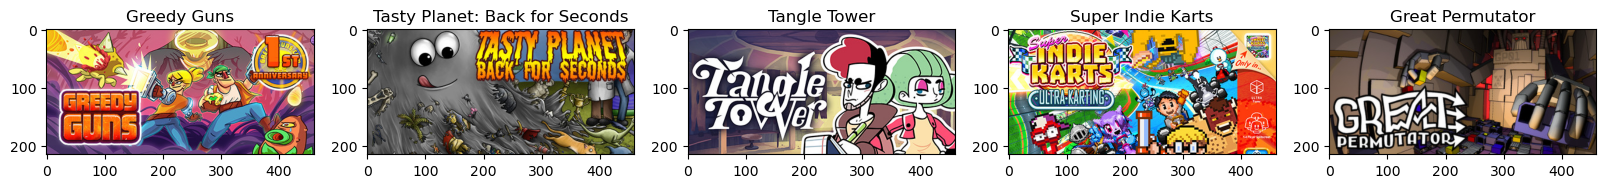

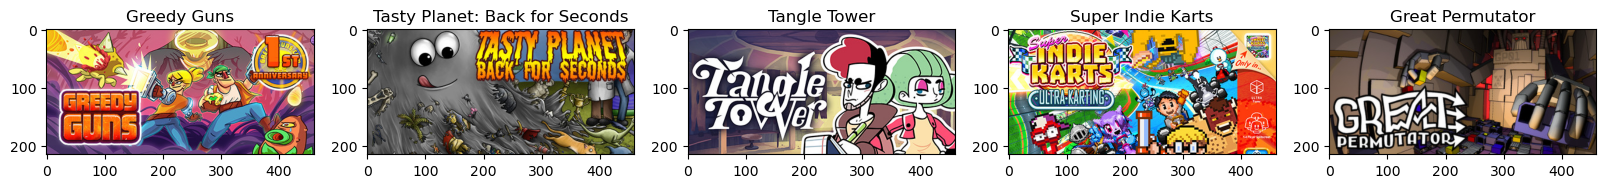

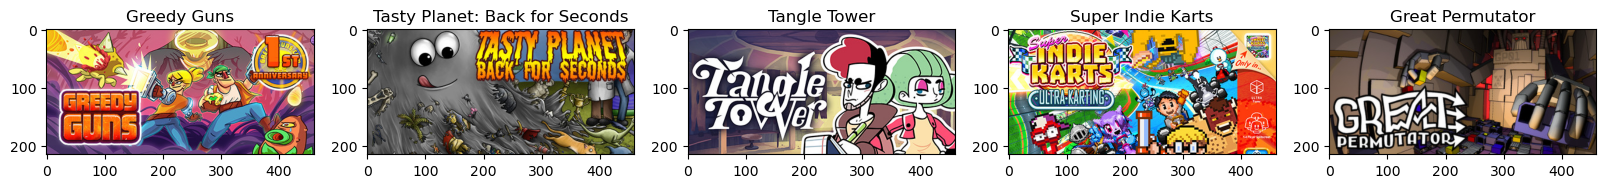

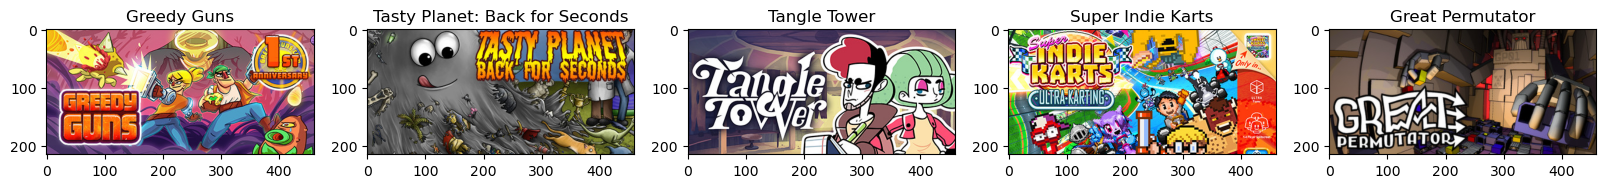

In [43]:
# 추천 결과를 저장할 데이터프레임을 생성합니다.
recommend_df = pd.DataFrame()

for i in range(len(name_list)):
    game_name = name_list[i]

    try:
        show_recommendations(game_name, df, cosine_similarities)
#         game_list=pd.concat(([game_list,recommend_info]))
        
    except:
        continue

print('추천 게임 개수 : ', len(game_list))

54669


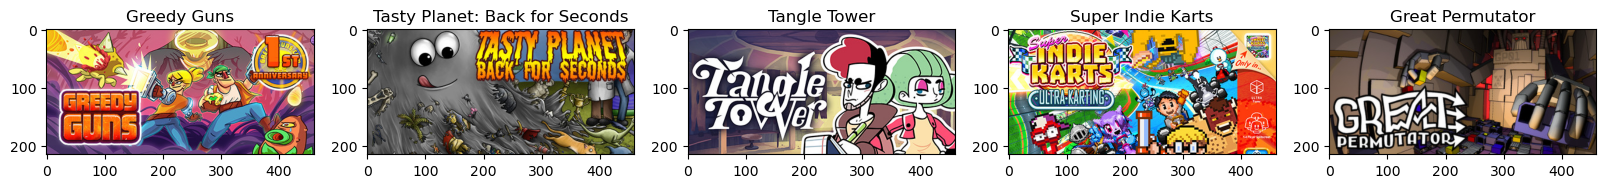

In [39]:
show_recommendations('Hades', df, cosine_similarities)